<h1 align="center"> Data Science as Applied to Weightlifting </h1>

<p> Data science is an increasingly popular field with important applications in our increasingly complex world with increasingly massive datasets. And, it's not an incredibly difficult field. This is an introduction to the process of data science, using an example dataset of weightlifting personal bests. </p> 

<h2> Background Information </h2>

<p> The dataset we're working with is about personal weightlifting records at certain other data points. Each piece of data is information from a single person - their age, bodyweight, sex, equipment, and personal best in three different lifts. We'll be using this data to predict a person's personal best for a bench press. </p>

<p> This section will provide explanations of each category of data, as not everyone is incredibly familiar with lifting, as well as some intuitive predictions. </p>

<p> Age: Age is a very familiar concept, and it has two possible effects on our data. For one, we know that the body reaches peak physical fitness relatively early in life, and degrades from there. So, we predict that older lifters have lower records. Also, since puberty is when the body starts to develop more muscle, we can expect younger lifters to be less effective. Finally, older age implies more experience and time spent training, and muscle development takes time. So, there is probably a sweet spot where individuals are close to their physical peak and experienced enough to have made serious progress. </p>

<p> Bodyweight: Individuals with more mass will have a greater raw amount of muscle, and are therefore more likely to be able to lift greater weights. In fact, it is not uncommon to measure performance as multiples of bodyweight rather than absolute weights. We can predict that higher bodyweight means higher maximum lifting weight, but that may not be a helpful scale. </p>

<p> Sex: This dataset refers exclusively to birth sex, so we will assume that all athletes are cisgender. This is an important fact to know, as it is well studied that testosterone makes a significant impact on musculature. We predict there to be a significant difference between male and female lifters across all categories. </p>

<p> Equipment: There are four categories of equipment in this dataset - raw, wrapped, single-ply, and multi-ply. Raw refers to a lifter who does not use any equipment to assist them, and wrapped refers to a lifter who uses wrist wraps for their lifting. </p>

<p> The remaining two categories use specific clothing where the material it is made from stores energy in the form of tension, which lifters can use to make a lift easier. When the athlete moves into the negative part of the lift, where they put themselves in a position of tension before the lift, the garment generates that tension. When the subsequent lift happens, it is released. Singly-ply and multi-ply refer to how many layers of that material are used, where more layers allow for more energy to be stored. </p>

<p> Lifts: There are three lifts this dataset records - squat, deadlift, and bench press.

The squat is performed by holding a weighted barbell against the back, squatting down, and then returning to standing. This works a number of muscles in the legs. 

The deadlift is performed by bending mostly through the knees to grab a floor-level barbell and pushing with the knees and pulling with the upper back until the knees and back are straight. This works mostly leg muscles, but also trains back muscles and requires strong arms.

Finally, the bench press is performed laying on a flat surface with a barbell held above the chest. The weight is lowered down to the chest and then pushed back to its original position. This primarily works the chest, as well as working the arms.

In general, of these three lifts, individuals can lift the most weight with a deadlift and the least with a bench press. This comes from the natural size and strength of the muscle groups used. 

Another relationship to look out for is how each lift affects the others. Since squat and deadlift are both leg focused, we would expect them to be highly correlated. However, bench press shares very little in common with either, besides deadlift also needing strong arms. But, we do predict a general correlation between all three lifts purely because higher scores in one lift implies higher general fitness. </p>


<h1> Preliminaries </h1>

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p> This dataset came split into four files, each with different information. This is done to make machine learning easier, which we'll get into later. For now, though, we want to combine everything into one big dataset we can look over and clean up if needed. </p>

<p> To briefly explain, the '_train' files contain most of the data and the '_test' files contain the remaining, smaller portion. The 'X' files contain every piece of information except the bench press personal best, which is contained in the 'y' files. Both 'X' and 'y' files contain an ID number for each row, which we will use to match rows. </p>

In [30]:
X_train = pd.read_csv("drive/MyDrive/X_train.csv")
X_test = pd.read_csv("drive/MyDrive/X_test.csv")
y_train = pd.read_csv("drive/MyDrive/y_train.csv")
y_test = pd.read_csv("drive/MyDrive/y_test.csv")

<h2> Data Management </h2>

<p> Now that we've loaded the data, we want to get it into a format that we can work with. To start, we want to make our data into a useful type. Specifically, numbers. This allows us to use machine learning algorithms to make predictions later on. </p>

<p> First of all, we want to examine our data and get an idea of what it looks like. In this specific case, since our data came separated, we're going to combine it first so we can examine every column easily, then we'll draw some insights in how to proceed. </p>

In [31]:
X_train['BestBenchKg'] = y_train['BestBenchKg']
X_test['BestBenchKg'] = y_test['BestBenchKg']
data = pd.concat([X_train, X_test], ignore_index=True)

display(data.head())

print("Number of unique names: ", len(data['Name'].unique()))
print("Number of unique player IDs: ", len(data['playerId'].unique()))
print("Number of rows: ", data.shape[0])

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0,125.0
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0,157.5
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0,145.0
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.5,60.0
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.5,60.0


Number of unique names:  23299
Number of unique player IDs:  30000
Number of rows:  30000


<p> There are a few things that immediately jump out. First of all, age, bodyweight, and all the lifts are numbers, so we don't need to touch those yet. Next, we have a playerId and a Name column, and we don't need both. Looking at the number of unique names, IDs, and rows, we see that all player IDs must be unique and some names are duplicates or missing. So, we can remove names.

Next, both Sex and Equipment are not numbers. In fact, they are strings with two or four options, respectively. To change that, we use a technique called one-hot encoding. Those two columns will be split into six columns, two for sex and four for equipment. Each of those columns represents one of the string options, and a row will have a 1 in that column if it originally had that value. </p>

In [32]:
data = data.drop('Name', axis=1)
data = pd.get_dummies(data, columns=['Sex', 'Equipment'])

display(data.head())

,playerId,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg,Sex_F,Sex_M,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps
0,19391.0,23.0,87.30,205.0,235.0,125.0,0,1,0,1,0,0
1,15978.0,23.0,73.48,220.0,260.0,157.5,0,1,0,0,0,1
2,27209.0,26.0,112.40,142.5,220.0,145.0,0,1,0,1,0,0
3,27496.0,35.0,59.42,95.0,102.5,60.0,1,0,0,1,0,0
4,20293.0,26.5,61.40,105.0,127.5,60.0,1,0,0,1,0,0


<p> Later, when I tried to do some data exploration, I noticed that some values were throwing errors. With some manual investigation of the data, I tracked the problem down - a few entries in the BestSquatKg column had an additional decimal point, where '123.4' was represented as '123..4', for example. This caused issues as the rest of the data could be naturally converted to a float, whereas these values couldn't. So, we iterate over the rows and change any problematic entries. </p>

In [33]:
for idx in range(data.shape[0]):
  val = data.iloc[idx, 3]
  if type(val) == str and '..' in val:
    data.iloc[idx, 3] = val.replace('..','.')

<p> This was not the only problem that arose while trying to do analysis. There are two more, which we deal with here.

First of all, a number of values in the squat column were negative. Since a negative squat weight doesn't really exist, these are problematic values. In this specific case, we handle them by just taking the absolute value of each entry. However, to do that, we first needed to convert every entry from a string to a float. We already knew that they would be strings, because the previous issue of repeating decimals was solved by transformations on strings.

Next, we want to figure out if there are any missing values. As it turns out, from our quick print statement and isnull(), we find that there are a few! Since there are only 420 of 30000 and we don't want to lose data, we just fill those entries in with the mean of their column. </p>

In [34]:
data['BestSquatKg'] = pd.to_numeric(data['BestSquatKg'])
data = data.apply(abs)

print(data.isnull().values.any())
print(data.isnull().values.sum())
data = data.fillna(data.mean())

display(data.head())

True
420


,playerId,Age,BodyweightKg,BestSquatKg,BestDeadliftKg,BestBenchKg,Sex_F,Sex_M,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps
0,19391.0,23.0,87.30,205.0,235.0,125.0,0,1,0,1,0,0
1,15978.0,23.0,73.48,220.0,260.0,157.5,0,1,0,0,0,1
2,27209.0,26.0,112.40,142.5,220.0,145.0,0,1,0,1,0,0
3,27496.0,35.0,59.42,95.0,102.5,60.0,1,0,0,1,0,0
4,20293.0,26.5,61.40,105.0,127.5,60.0,1,0,0,1,0,0


<h2> Data Exploration </h2>

<p> Now that our data is in a comfortable format and easy to use, we can start to explore it. To start, we'll graph a few trends. Since we made some predictions, we'll start with seeing if those are right.

Since it's easier to understand a graph of a continuous variable over a continuous variable, we won't directly graph discrete variables like sex and equipment to start with. We will, however, distinguish points of either sex by color, since that is an important hypothesis. </p>

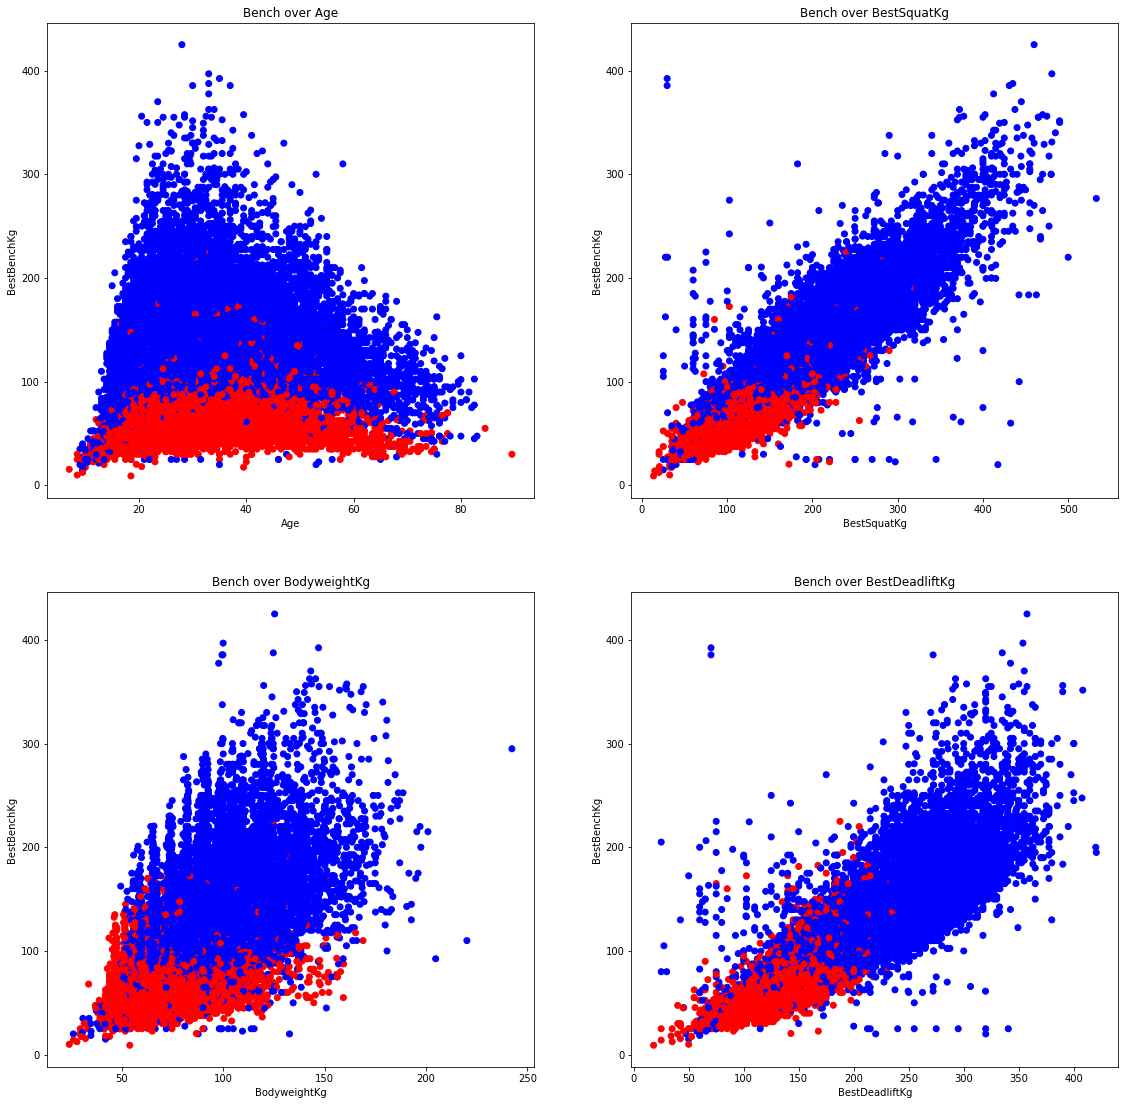

In [35]:
cols = ['Age', 'BodyweightKg', 'BestSquatKg', 'BestDeadliftKg']

y = data['BestBenchKg']

fig, ax = plt.subplots(2,2)

i,j = 0,0
for col in cols:
  c = np.where(data['Sex_F'] == 1, 'r', 'b')
  ax[i,j].scatter(data[col], y, c=c)
  ax[i,j].set_title('Bench over ' + col)
  ax[i,j].set_xlabel(col)
  ax[i,j].set_ylabel('BestBenchKg')
  i += 1
  if i == 2:
    i = 0
    j += 1
fig.set_size_inches((19.2,19.2))
plt.show()

<p> Seeing the above, there are a few trends that are worth noting. 

Firstly, our prediction about age seems to be accurate. Younger athletes have lower values, age 20-40 athletes perform the best - the sweet spot we were concerned about - and older athletes tend to worsen with age.

Secondly, for both lifts, there is a trend where increase in one corresponds to an increase in the other.

Also, bodyweight plays the role we expected, where higher bodyweight individuals tend to lift heavier weights.

Finally, it seems to be a common trend where datapoints from female individuals have smaller values than datapoints from male individuals. We investigate this further by dividing the data by sex and comparing. </p>

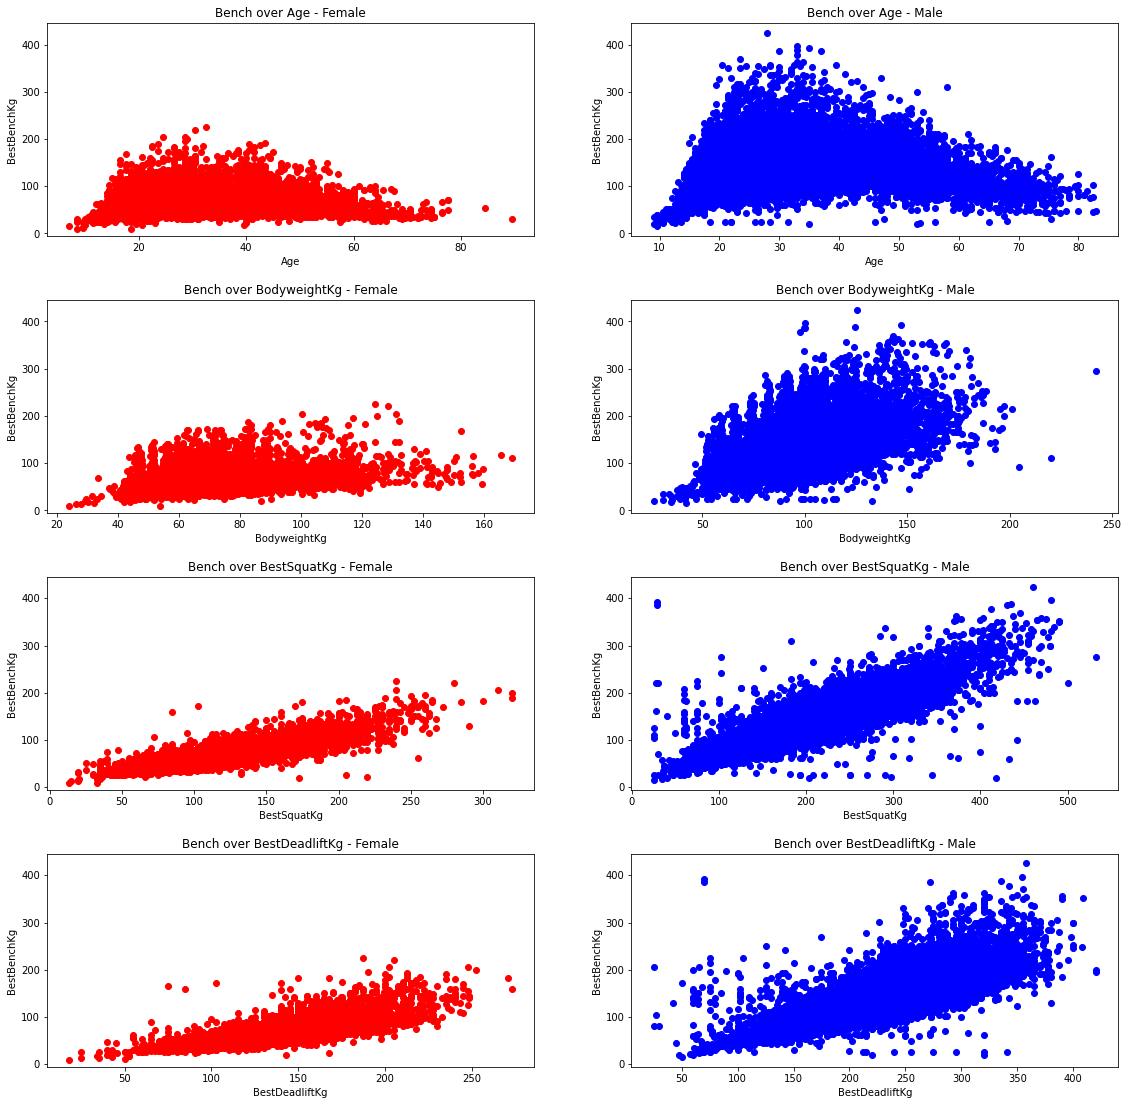

In [36]:
yF = data.loc[data['Sex_F'] == 1]['BestBenchKg']
yM = data.loc[data['Sex_M'] == 1]['BestBenchKg']

xF = data.loc[data['Sex_F'] == 1]
xM = data.loc[data['Sex_M'] == 1]

fig, ax = plt.subplots(4,2)

i,j = 0,0
for col in cols:
  ax[i,0].scatter(xF[col], yF, c='r')
  ax[i,1].scatter(xM[col], yM, c='b')
  ax[i,0].set_title('Bench over ' + col + ' - Female')
  ax[i,0].set_xlabel(col)
  ax[i,0].set_ylabel('BestBenchKg')
  ax[i,0].set_ylim(ax[i,1].get_ylim())
  ax[i,1].set_title('Bench over ' + col + ' - Male')
  ax[i,1].set_xlabel(col)
  ax[i,1].set_ylabel('BestBenchKg')
  i += 1
fig.set_size_inches((19.2,19.2))
plt.subplots_adjust(hspace=0.3)
plt.show()

<p> Since we make the plots have the same scale, we can easily see that female athletes have a major disadvantage for lifting heavier weights. So, we expect that sex will be one of the most impactful parameters for our prediction algorithms. But, for further data exploration, it would likely make sense to divide the data. </p>

<p> We will convert to looking at performance as a ratio with bodyweight. This is a common practice when evaluating strength, as higher bodyweight often comes with more muscle mass and therefore power. In fact, we can see this trend clearly in the above graphs, especially for males. So, this helps us normalize the data to reduce the impact of certain outliers. </p>

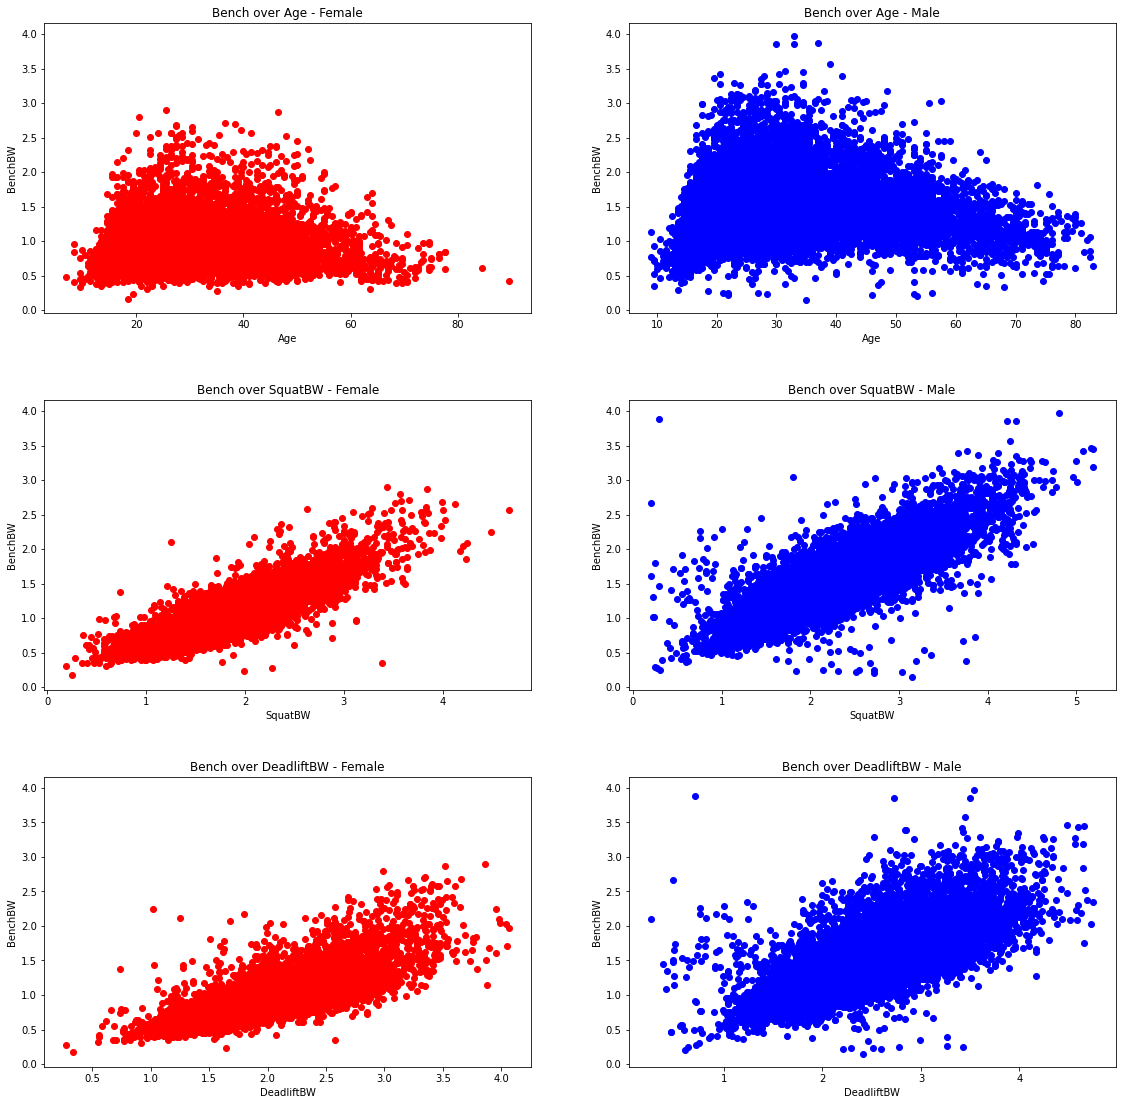

In [37]:
data['SquatBW'] = data['BestSquatKg'] / data['BodyweightKg']
data['DeadliftBW'] = data['BestDeadliftKg'] / data['BodyweightKg']
data['BenchBW'] = data['BestBenchKg'] / data['BodyweightKg']

yF = data.loc[data['Sex_F'] == 1]['BenchBW']
yM = data.loc[data['Sex_M'] == 1]['BenchBW']

xF = data.loc[data['Sex_F'] == 1]
xM = data.loc[data['Sex_M'] == 1]

fig, ax = plt.subplots(3,2)

newcols = ['Age', 'SquatBW', 'DeadliftBW']

i,j = 0,0
for col in newcols:
  ax[i,0].scatter(xF[col], yF, c='r')
  ax[i,1].scatter(xM[col], yM, c='b')
  ax[i,0].set_title('Bench over ' + col + ' - Female')
  ax[i,0].set_xlabel(col)
  ax[i,0].set_ylabel('BenchBW')
  ax[i,0].set_ylim(ax[i,1].get_ylim())
  ax[i,1].set_title('Bench over ' + col + ' - Male')
  ax[i,1].set_xlabel(col)
  ax[i,1].set_ylabel('BenchBW')
  i += 1
fig.set_size_inches((19.2,19.2))
plt.subplots_adjust(hspace=0.3)
plt.show()

<h2> Hypotheses and Analysis </h2>

<p> Now that we have a good picture of our data, we want to draw insights from it. Specifically, as we are predicting a variable on a sliding scale - best bench press weight - using a number of different variables, this is a regression problem. </p>

<p> The most basic form of regression is linear regression, which your brain likely naturally did when looking that the previous graphs. What's the trend? If I were to draw a line that most accurately predicted a y value given a certain x value, what would that line look like? That's linear regression. We're going to use the computer to generalize this process. Instead of using one value to predict another, we're going to use all of them. We're still drawing a line just in around a dozen dimensions. </p>

<p> As it turns out, while doing this work, the summary of our models suggested that a model with raw weight numbers and bodyweight as a variable to predict from had high colinearity, or variables having too similar of an impact. This matches with our idea that bodyweight and lifting power increase linearly. So, to avoid this, we use bodyweight ratios instead of raw numbers and drop bodyweight entirely. </p>

In [38]:
databw = data.drop(['BestBenchKg', 'playerId', 'BodyweightKg', 'BestSquatKg', 'BestDeadliftKg', 'Sex_F'], axis=1, inplace=False)
Xbw = databw.drop(['BenchBW'], axis=1, inplace=False)
ybw = databw['BenchBW']

linbw = sm.OLS(ybw, Xbw).fit()
print(linbw.summary())

                            OLS Regression Results                            
Dep. Variable:                BenchBW   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                 1.574e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        04:19:46   Log-Likelihood:                 4552.0
No. Observations:               30000   AIC:                            -9088.
Df Residuals:                   29992   BIC:                            -9021.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                      0.0026 

<p> To read the above linear model, the most relevant information is the coef column. These are the raw numbers we would multiply each variable by to get a prediction. For example, for each year an individual has lived, we expect an increase of bench press performance by .0026 times bodyweight. Or, for male individuals, we expect a .258 times bodyweight increase compared to females.

So, we have a linear model for our data. But, we need to check if it's any good. After all, we as humans might have missed a facet of this data that the computer found, and the relationship is not actually linear. 

In order to test whether our dataset is linear or not, we check the p-values for each coefficient. A p-value is a common statistical concept, meaning if we assume some hypothesis - no linear relationship in this case - then we have a probability of p to obtain our exact results. A common p value for significance is 0.05, which for our case, means that if there is no linear relationship, we have a 5% or less chance of getting the data that we did.

Looking at the summary that statsmodels provides, the p-values, which is the fourth labelled column, P>|t|, the only non-significant variable is single-ply equipment. In other words, the major variables of our dataset are all very linearly related. Thus, we can confidently use our model. </p>

<p> Next, we want to see how well our model performs. A common metric to evaluate the performance of a linear model is mean squared error (MSE). This is calculated by taking every real value minus its predicted value and squaring it. Those squares are then averaged over the dataset to give our MSE. It's a hard metric to judge, as there is no absolute scale for it. Models with high mean squared error can still be good, but generally, the closer to zero, the better.

We augment our testing with a version of a process called k-fold cross validation. Essentially, we take our data and randomly split it into eighty percent training data and twenty percent testing data. We then create a model from the training data and apply its predictions to both the training and testing data to how its performance reacts. If performance is consistent across training and testing, we have a generalizable model. If there is great variation across different train and test splits, then we can make hypotheses about our data distribution. There are a great many insights we can draw from this process. </p>

In [39]:
for i in range(0, 10):
  train, test = train_test_split(databw, test_size=0.2)

  Xtrain = train.drop(['BenchBW'], axis=1)
  Xtest = test.drop(['BenchBW'], axis=1)
  ytrain = train['BenchBW']
  ytest = test['BenchBW']

  trainpreds = linbw.predict(Xtrain)
  testpreds = linbw.predict(Xtest)

  trainmse = mean_squared_error(trainpreds, ytrain)
  testmse = mean_squared_error(testpreds, ytest)

  print("Iteration "+str(i)+": Training Mean Squared Error: "+
        "{:1.4f}".format(trainmse)+", Testing Mean Squared Error: "+"{:1.4f}".format(testmse)+
        ", Difference: "+"{:1.4f}".format(trainmse-testmse))

Iteration 0: Training Mean Squared Error: 0.0436, Testing Mean Squared Error: 0.0416, Difference: 0.0020
Iteration 1: Training Mean Squared Error: 0.0433, Testing Mean Squared Error: 0.0428, Difference: 0.0006
Iteration 2: Training Mean Squared Error: 0.0433, Testing Mean Squared Error: 0.0430, Difference: 0.0003
Iteration 3: Training Mean Squared Error: 0.0437, Testing Mean Squared Error: 0.0411, Difference: 0.0026
Iteration 4: Training Mean Squared Error: 0.0435, Testing Mean Squared Error: 0.0419, Difference: 0.0016
Iteration 5: Training Mean Squared Error: 0.0429, Testing Mean Squared Error: 0.0446, Difference: -0.0017
Iteration 6: Training Mean Squared Error: 0.0430, Testing Mean Squared Error: 0.0442, Difference: -0.0012
Iteration 7: Training Mean Squared Error: 0.0430, Testing Mean Squared Error: 0.0442, Difference: -0.0012
Iteration 8: Training Mean Squared Error: 0.0432, Testing Mean Squared Error: 0.0431, Difference: 0.0001
Iteration 9: Training Mean Squared Error: 0.0434, Te

<p> As we see from our tests, the mean squared error is under 0.05, which is close to zero and likely pretty good. It's also very consistent across iterations, which is a good sign for our model not needing specific sections of the data to perform. Also, the difference between training and testing is incredibly low, which is quite good. This means our model is very generalizable, as it predicts with similar accuracy on data it's never seen before. We can comfortably trust the predictions this model makes on new data. </p>

<h2> What Did we Learn? </h2>

<p> There are a few things that we now know. For one, our predictions from the beginning aren't speculation, we have statistics that show them to be true. For example, we know that the most impactful factors on performance are sex, squat personal best, and deadlift personal best, both with respect to bodyweight. So, for an individual looking to increase their bench press personal best, the answer is rather simply, and somewhat underwhelmingly, better fitness overall. </p>

<p> Not only do we know that certain elements have an effect on bench press personal bests, but we also know by how much in context. We can even have the computer estimate a bench press personal best with high accuracy, which you can directly apply to your own training. </p>